In [1]:
%matplotlib notebook

import gillespy2
from gillespy2.solvers.numpy import NumPySSASolver
from tsfresh.feature_extraction.settings import MinimalFCParameters
import numpy as np

from dask.distributed import Client

## Define Model

In [2]:
class ToggleSwitch(gillespy2.Model):
    """ Gardner et al. Nature (1999)
    'Construction of a genetic toggle switch in Escherichia coli'
    """
    def __init__(self, parameter_values=None):
        # Initialize the model.
        gillespy2.Model.__init__(self, name="toggle_switch")
        # Parameters
        alpha1 = gillespy2.Parameter(name='alpha1', expression=1)
        alpha2 = gillespy2.Parameter(name='alpha2', expression=1)
        beta = gillespy2.Parameter(name='beta', expression="2.0")
        gamma = gillespy2.Parameter(name='gamma', expression="2.0")
        mu = gillespy2.Parameter(name='mu', expression=1.0)
        self.add_parameter([alpha1, alpha2, beta, gamma, mu])

        # Species
        U = gillespy2.Species(name='U', initial_value=10)
        V = gillespy2.Species(name='V', initial_value=10)
        self.add_species([U, V])

        # Reactions
        cu = gillespy2.Reaction(name="r1",reactants={}, products={U:1},
                propensity_function="alpha1/(1+pow(V,beta))")
        cv = gillespy2.Reaction(name="r2",reactants={}, products={V:1},
                propensity_function="alpha2/(1+pow(U,gamma))")
        du = gillespy2.Reaction(name="r3",reactants={U:1}, products={},
                rate=mu)
        dv = gillespy2.Reaction(name="r4",reactants={V:1}, products={},
                rate=mu)
        self.add_reaction([cu,cv,du,dv])
        self.timespan(np.linspace(0,50,101))

toggle_model = ToggleSwitch()

## Define simulator function

In [3]:
def set_model_parameters(params, model):
    """ params - array, needs to have the same order as model.listOfParameters """
    for e, (pname, p) in enumerate(model.listOfParameters.items()):
        model.get_parameter(pname).set_expression(params[e])
    return model

# model need be passed as argument for distributed comp.
def simulator(params, model):
    
    from gillespy2.solvers.numpy.ssa_solver import MaxStateReached
    from mio.stochmet.stochmet import EventFired
    
    model_update = set_model_parameters(params, model)
    num_trajectories = 1 #TODO: howto handle ensembles
    try:
        res = model_update.run(solver=NumPySSASolver, show_labels=False, number_of_trajectories=num_trajectories, max_state=100)
        tot_res = res[0][:,1:] #should not contain timepoints
    except MaxStateReached:
        raise EventFired
    
    
    return np.array(tot_res)

## Define parameter sampler

In [4]:
default_param = np.array(list(toggle_model.listOfParameters.items()))[:,1]
bound = []
for exp in default_param:
    bound.append(float(exp.expression))
    
bound = np.array(bound)

class Sampler():
    
    def __init__(self, min_, max_):
        self.name = 'Uniform'
        self.min_ = min_
        self.max_ = max_
        self.dim = len(max_)
    
    def generate(self, n_points):
        points = np.random.uniform(self.min_, self.max_, (n_points, self.dim))
        return points

sampler = Sampler(min_=bound*0.01, max_=bound*100)

## Start local cluster using dask client

In [6]:
c = Client()
c

Client Scheduler: tcp://127.0.0.1:57554,Cluster Workers: 4 Cores: 4 Memory: 16.83 GB


## Initiate StochMET

In [8]:
from mio.stochmet.stochmet import StochMET

#Arg: "model" enables us the change which model to be used
simulator2 = lambda x : simulator(x, model=toggle_model)

#will use default minimal set of features
met = StochMET(simulator=simulator2, sampler=sampler)

## Run parameter sweep (will persist and running in background)

In [9]:
met.compute(n_points=100, n_species=2)

## Explore the result
Here we will explore parameter points expressed in feature space using a dimension reduction method. User can interact with points and label points according to different model behavior

In [10]:
#First lets add some appropiate information about the model and features
met.data.configurations['listOfParameters'] = list(toggle_model.listOfParameters.keys())
met.data.configurations['listOfSpecies'] = list(toggle_model.listOfSpecies.keys())
met.data.configurations['listOfSummaries'] = met.summaries.features
met.data.configurations['timepoints'] = toggle_model.tspan

<IPython.core.display.Javascript object>


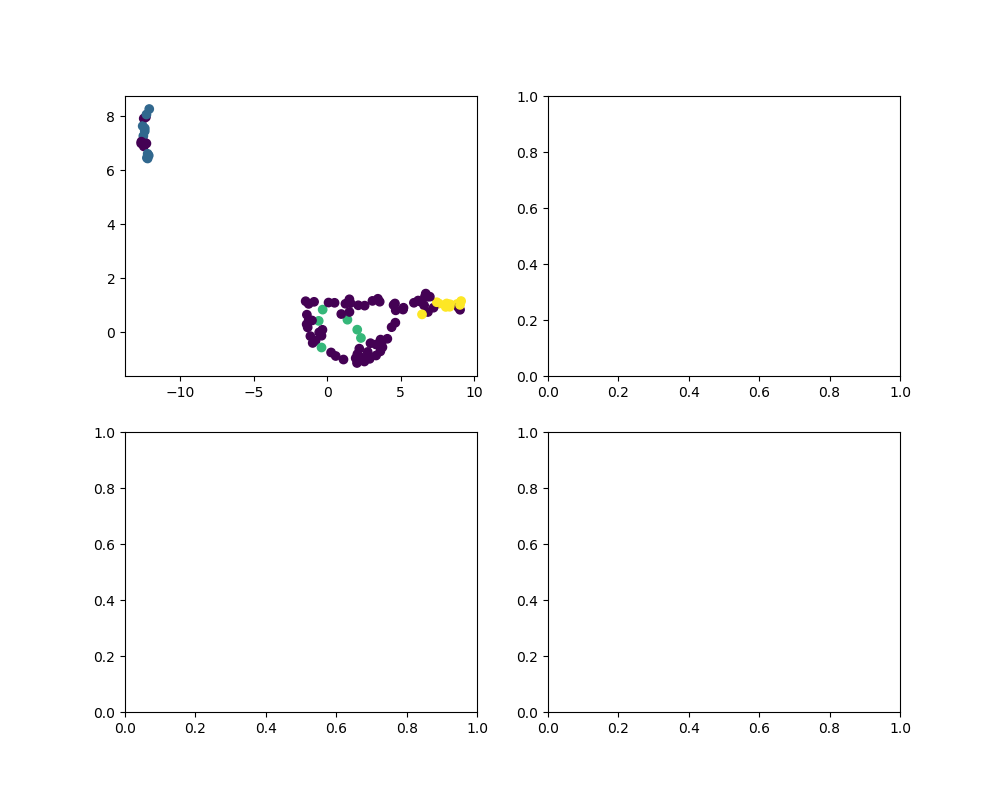

Button(description='Clear all', style=ButtonStyle())

Button(description='Submit', style=ButtonStyle())

IntSlider(value=0, max=10, min=-1)

Dropdown(description='Species plot 1', options={'U': 0, 'V': 1}, value=0)

Dropdown(description='Species plot 2', index=1, options={'U': 0, 'V': 1}, value=1)

,alpha1,alpha2,beta,gamma,mu
0,78.977776,10.793719,67.818405,9.500773,44.047007
1,82.150795,42.867997,74.527741,45.984085,7.228375
2,23.754956,88.337782,109.919253,128.493147,8.451108
3,45.076704,82.941372,168.922265,130.641497,13.586967
4,17.707083,6.331781,167.917312,118.131623,44.288748
5,93.797796,58.282674,117.676926,18.402765,76.326265
6,33.790056,22.314539,196.352597,13.855799,2.998667
7,45.413590,89.220134,135.961569,40.159325,75.292612
8,96.279744,56.242953,16.171855,76.885870,67.691366
9,33.136732,23.347473,100.711587,160.583092,52.030432


In [11]:
# Here we use UMAP for dimension reduction and collect the data from persited storage
met.explore(dr_method='umap', from_distributed=True)

## Once a few points has been added we can use Semi-supervised learning

In [14]:
from mio.models.label_propagation import LPModel
#here lets use the dimension reduction embedding as input data
data = met.dr_model.embedding_

model_lp = LPModel()
#train using basinhopping
model_lp.train(data, met.data.user_labels, min_=0.01, max_=10, niter=50)

basinhopping step 0: f 0.297109
basinhopping step 1: f 0.296887 trial_f 0.296887 accepted 1  lowest_f 0.296887
found new global minimum on step 1 with function value 0.296887
basinhopping step 2: f 0.296947 trial_f 0.296947 accepted 1  lowest_f 0.296887
basinhopping step 3: f 0.296935 trial_f 0.296935 accepted 1  lowest_f 0.296887
basinhopping step 4: f 0.301499 trial_f 0.301499 accepted 1  lowest_f 0.296887
basinhopping step 5: f 0.298683 trial_f 0.298683 accepted 1  lowest_f 0.296887
basinhopping step 6: f 0.298211 trial_f 0.298211 accepted 1  lowest_f 0.296887
basinhopping step 7: f 0.297023 trial_f 0.297023 accepted 1  lowest_f 0.296887
basinhopping step 8: f 0.296996 trial_f 0.296996 accepted 1  lowest_f 0.296887
basinhopping step 9: f 0.296887 trial_f 0.296887 accepted 1  lowest_f 0.296887
basinhopping step 10: f 0.297178 trial_f 0.297178 accepted 1  lowest_f 0.296887
basinhopping step 11: f 0.300189 trial_f 0.300189 accepted 1  lowest_f 0.296887
basinhopping step 12: f 0.297946 

In [17]:
# just to vislualize the result we will map the label distribution to the user_labels (will enable us to see the LP model 
# output when using "explore")

user_labels = np.copy(met.data.user_labels)
met.data.user_labels = model_lp.model.label_distributions_[:,0]

<IPython.core.display.Javascript object>


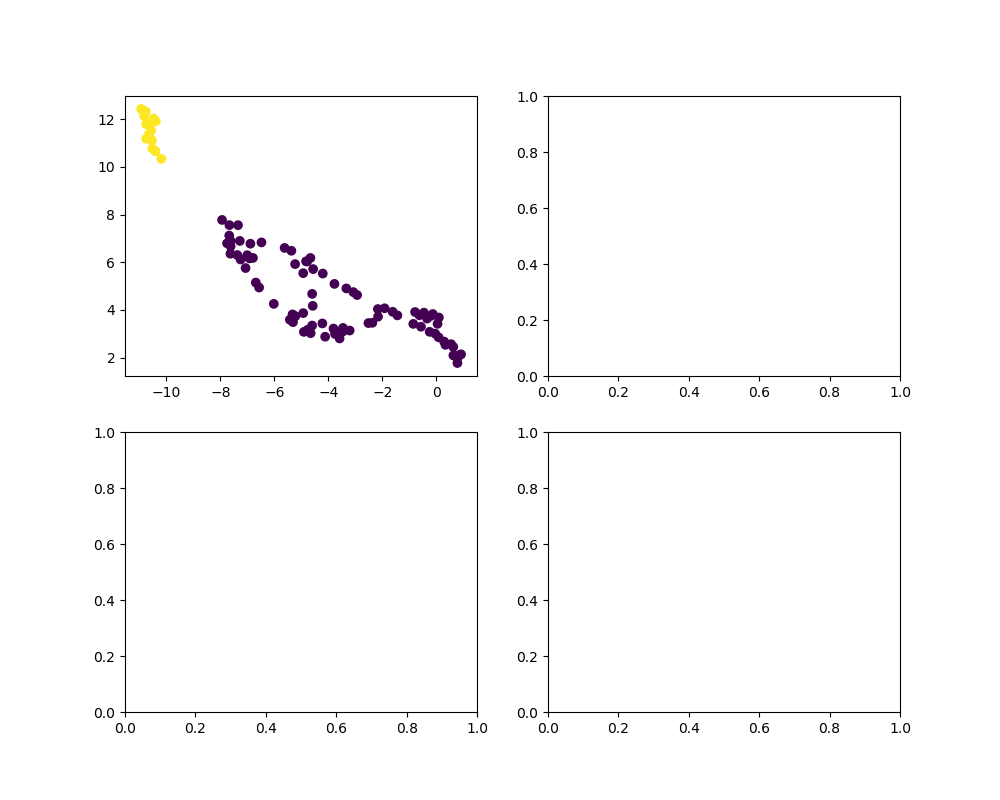

Button(description='Clear all', style=ButtonStyle())

Button(description='Submit', style=ButtonStyle())

IntSlider(value=0, max=10, min=-1)

Dropdown(description='Species plot 1', options={'U': 0, 'V': 1}, value=0)

Dropdown(description='Species plot 2', index=1, options={'U': 0, 'V': 1}, value=1)

,alpha1,alpha2,beta,gamma,mu
0,78.977776,10.793719,67.818405,9.500773,44.047007
1,82.150795,42.867997,74.527741,45.984085,7.228375
2,23.754956,88.337782,109.919253,128.493147,8.451108
3,45.076704,82.941372,168.922265,130.641497,13.586967
4,17.707083,6.331781,167.917312,118.131623,44.288748
5,93.797796,58.282674,117.676926,18.402765,76.326265
6,33.790056,22.314539,196.352597,13.855799,2.998667
7,45.413590,89.220134,135.961569,40.159325,75.292612
8,96.279744,56.242953,16.171855,76.885870,67.691366
9,33.136732,23.347473,100.711587,160.583092,52.030432


In [19]:
met.explore(dr_method='umap', from_distributed=False)

In [20]:
met.data.user_labels = user_labels